**Chương 18 – Học Tăng Cường**

_Jupyter Notebook này chứa tất cả mã lập trình mẫu và lời giải cho các bài tập trong chương 18_.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mlbvn/handson-ml2-vn/blob/main/18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mlbvn/handson-ml2-vn/blob/main/18_reinforcement_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Cài đặt
Đầu tiên hãy nhập một vài mô-đun thông dụng, đảm bảo rằng Matplotlib sẽ vẽ đồ thị ngay trong notebook, và chuẩn bị một hàm để lưu đồ thị. Ta cũng kiểm tra xem Python phiên bản từ 3.5 trở lên đã được cài đặt hay chưa (mặc dù Python 2.x vẫn có thể hoạt động, phiên bản này đã không còn sử dụng nên chúng tôi rất khuyến khích việc sử dụng Python 3), cũng như Scikit-Learn ≥ 0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym~=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Giới thiệu về OpenAI gym

Trong notebook này ta sẽ sử dụng [OpenAI gym](https://gym.openai.com/), một bộ công cụ để phát triển và so sánh các thuật toán Học Tăng Cường. Nó cung cấp nhiều môi trường để *các tác nhân* học của bạn tương tác. Hãy bắt đầu bằng việc tải `gym`:

In [2]:
import gym

Hãy liệt kê tất cả các môi trường có sẵn:

In [3]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

Cart-Pole là một môi trường rất đơn giản bao gồm việc một chiếc xe đẩy có thể di chuyển qua trái hoặc qua phải và cột được đặt thẳng đứng trên nó. Tác nhân phải di chuyển xe đẩy qua trái hoặc phải để giữ cho cột thẳng đứng.

In [4]:
env = gym.make('CartPole-v1')

Hãy khởi tạo môi trường bằng cách gọi phương thức `reset()`. Việc này trả về một quan sát:

In [5]:
env.seed(42)
obs = env.reset()

Quan sát thay đổi tuỳ thuộc vào môi trường. Trong trường hợp này, đó là mảng NumPy 1D gồm 4 số chấm động: chúng đại diện cho vị trí nằm ngang của xe đẩy, vận tốc của nó, gốc của cột (0 = thẳng đứng) và vận tốc góc.

In [6]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

Một môi trường có thể được trực quan hoá bằng cách gọi phường thức `render()` của nó, và bạn có thể chọn cách thức kết xuất (các tuỳ chọn kết xuất tuỳ thuộc vào môi trường).

**Cảnh báo**: một vài môi trường (bao gồm Cart-Pole) yêu cầu truy cập vào màn hình của bạn, nghĩa là sẽ mở một cửa sổ tách biệt, ngay cả khi bạn chỉ định `mode="rgb_array"`. Thông thường bạn có thể bỏ qua cửa sổ đó một cách an toàn. Tuy nhiên, nếu Jupyter đang chạy trên một máy chủ không đầu (nghĩa là, không có màn hình), nó sẽ đưa ra một lỗi ngoại lệ. Một các để tránh điều này là cài đặt một máy chủ X giả như [Xvfb](http://en.wikipedia.org/wiki/Xvfb). Trên Debian hoặc Ubuntu:

```bash
$ apt update
$ apt install -y xvfb
```

Tiếp đó bạn có thể bắt đầu Jupyter sử dụng câu lệnh `xvfb-run`:

```bash
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

Một cách khác, bạn cũng có thể cài đặt thư viện Python [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) đóng gói Xvfb:

```bash
%pip install -U pyvirtualdisplay
```

Và chạy đoạn mã sau:

In [7]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [8]:
env.render()

True

Trong ví dụ này ta sẽ chỉ định `mode="rgb_array"` để thu được ảnh của môi trường dưới dạng mảng NumPy:

In [9]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [10]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

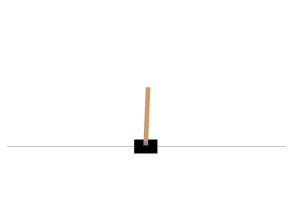

In [11]:
plot_environment(env)
plt.show()

Hãy xem cách tương tác với một môi trường. Tác nhân của bạn sẽ cần chọn một hành động từ một "trường hành động" (tập hợp của các hành động có thể xảy ra).
Hãy xem trường hành động của môi trường trông như thế nào:

In [12]:
env.action_space

Discrete(2)

Vâng, chỉ có hai hành động có thể: tăng tốc về phía trái hoặc về phía phải.

Vì cái cột nghiêng về phái phải (`obs[2] > 0`), hãy tăng tốc xay đẩy về phía phải:

In [13]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

Lưu ý rằng xe đẩy bây giờ di chuyển về phía phải (`obs[1] > 0`). Cái cột vẫn nghiêng về phía phải (`obs[2] > 0`), nhưng vận tốc góc bây giờ có giá trị âm (`obs[3] < 0`), vì vậy nó sẽ có khả năng nghiêng về phía trái sau bước tiếp theo.

Saving figure cart_pole_plot


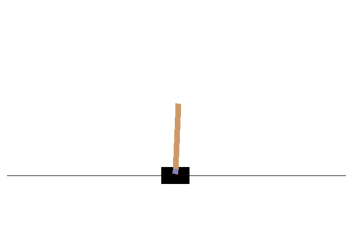

In [14]:
plot_environment(env)
save_fig("cart_pole_plot")

Trông có vẻ nó hoạt động theo cách mà ta yêu cầu!

Môi trường cũng cho tác nhân biết nó nhận được bao nhiêu điểm thưởng trong suốt bước cuối cùng:

In [15]:
reward

1.0

Khi trò chơi kết thúc, môi trường trả về `done=True`:

In [16]:
done

False

Cuối cùng, `info` là một từ điển dành riêng cho môi trường có thể cung cấp một số thông tin bổ sung hữu ích cho việc sửa lỗi hoặc huấn luyện. Vi dụ, trong một số trò chơi, nó có thể cho biết tác nhân có bao nhiêu mạng.

In [17]:
info

{}

Chuỗi các bước giữa thời điểm môi trường được thiết lập lại đến khi nó hoàn thành gọi là một "tập" (episode). Cuối một tập (nghĩa là khi `step()` trả về `done=True`), bạn nên thiết lập lại môi trường trước khi tiếp tục sử dụng nó.

In [18]:
if done:
    obs = env.reset()

Bây giờ làm sao để giữ cho cái cột thẳng đứng? Ta cần định nghĩa một _chính sách_ cho việc này. Đây là chiến thuật mà tác nhân sẽ sử dụng để chọn một hành động ở mỗi bước. Nó có thể sử dụng tất cả các hành động và quan sát quá khứ để quyết định phải làm gì.

# Chính sách mã hoá cứng đơn giản

Hãy lập trình cứng một chiến thuật đơn giản: nếu cái cột bị nghiêng qua trái, thì đẩy xe đẩy qua trái, và _ngược lại_. Hãy xem liệu chiến thuật này có hoạt động không:

In [19]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [20]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

Ổn, như kỳ vọng, chiến thuật này hơi quá cơ bản: điều tốt nhất nó làm là giữ cho cột đứng chỉ trong 68 bước. Môi trường này được xem là được giải quyết nếu tác nhân giữ cái cột thẳng đứng trong 200 bước.

Hãy trực quan hoá một tập:

In [21]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

Bây giờ xem hiển thị hình ảnh động:

In [22]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [23]:
plot_animation(frames)

Rõ ràng hệ thống không ổn định và sau chỉ vài chao đảo, cái cột bị nghiêng quá mức: trò chơi kết thúc. Ta cần thông minh hơn thế!

# Chính sách Mạng Nơ-ron 

Hãy tạo một mạng nơ-ron nhận quan sát làm đầu vào và xuất ra xác suất của hành động cần thực hiện cho mỗi quan sát. Để chọn một hành động, mạng sẽ ước tính một xác suất cho mỗi hành động, tiếp đó ta sẽ chọn một hành động ngẫu nhiên tuỳ theo các xác suất ước tính. Trong trường hợp môi trường của Cart-Pole, chỉ có hai hành động có thể xảy ra (trái hoặc phải), vì vậy ta chỉ cần một nơ-ron đầu ra: nó sẽ xuất ra xác suất `p` của hành động 0 (trái), và dĩ nhiên xác suất của hành động 1 (phải) sẽ là `1-p`.

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

Trong môi trường cụ thể này, các hành động và quan sát quá khứ có thể được bỏ qua một cách an toàn, vì mỗi quan sát chứa một trọng thái đầy đủ của môi trường. Nếu có vài trạng thái ẩn thì bạn cố thể cần cân nhắc các hành động và quan sát quá khứ để cố gắng suy ra trạng thái ẩn của môi trường. Ví dụ, nếu môi trường chỉ tiết lộ vị trí của xe đẩy nhưng không cho biết vận tốc của nó, bạn phải cân nhắc không chỉ quan sát hiện tại mà còn quan sát trước đó để ước tính vận tốc hiện tại. Một ví dụ khác là nếu các quan sát bị nhiễu: bạn muốn sử dụng một vài quan sát để ước tính trạng thái hiện tại có khả năng xảy ra nhất. Vấn đề của ta, vì vậy, đơn giản nhất có thể: quan sát hiện tại không bị nhiễu và chứa trạng thái đầy đủ của môi trường.

Bạn có thể thắc mắc tại sao ta dự định chọn một hành động ngẫu nhiên dựa trên xác suất do mạng chính sách đưa ra, thay vì chỉ chọn hành động có xác suất cao nhất. Cách tiếp cận này cho phép tác nhân tìm thấy sự cân bằng phù hợp giữa _khám phá_ các hành động mới và _khai thác_ các hành động được biết là hoạt động tốt. Đây là một phép loại suy: giả sử bạn đến một nhà hàng lần đầu tiên, và tất cả các món ăn đều trông hấp dẫn như nhau nên bạn chọn ngẫu nhiên một món. Nếu nó ngon, bạn có thể tăng xác suất đặt món đó vào lần sau, nhưng bạn không nên tăng xác suất đó lên 100%, nếu không, bạn sẽ không bao giờ thử các món khác, một số món có thể còn ngon hơn món mà bạn đã thử.

Hãy viết một hàm nhỏ chạy mô hình để phát một tập và trả về các khung hình để chúng ta có thể hiển thị hoạt ảnh:

In [25]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

Bây giờ, hãy xem mạng chính sách được khởi tạo ngẫu nhiên này hoạt động tốt như thế nào:

In [26]:
frames = render_policy_net(model)
plot_animation(frames)

Vâng ... khá tệ. Mạng lưới nơ-ron sẽ phải học cách làm tốt hơn. Trước tiên, hãy xem liệu nó có khả năng học chính sách cơ bản mà chúng ta đã sử dụng trước đó: đi sang trái nếu cột nghiêng sang trái và đi sang phải nếu cột nghiêng sang phải.

Chúng ta có thể thực hiện song song cùng một mạng chơi trong 50 môi trường khác nhau (điều này sẽ cung cấp cho ta một loạt huấn luyện đa dạng ở mỗi bước) và huấn luyện trong 5000 lần lặp lại. Ta cũng cài đặt lại môi trường khi chúng hoàn tất. Chúng ta huấn luyện mô hình bằng cách sử dụng vòng huấn luyện tùy chỉnh để có thể dễ dàng sử dụng các dự đoán ở mỗi bước huấn luyện nhằm cải thiện môi trường.

In [27]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.094

In [28]:
frames = render_policy_net(model)
plot_animation(frames)

Có vẻ như nó đã học chính sách một cách chính xác. Bây giờ hãy xem liệu nó có thể tự học một chính sách tốt hơn không. Chính sách mà cái cột không lắc lư nhiều như vậy.

# Các Gradient Chính Sách

Để huấn luyện mạng nơ-ron này, chúng ta cần xác định xác suất mục tiêu `y`. Nếu một hành động tốt, ta nên tăng xác suất của nó, và ngược lại nếu nó xấu, ta nên giảm nó. Nhưng làm sao chúng ta biết một hành động là tốt hay xấu? Vấn đề là hầu hết các hành động đều có hiệu ứng trễ, vì vậy khi bạn giành được hoặc mất điểm trong một tập, không rõ hành động nào đã góp phần vào kết quả này: đó có phải là hành động cuối cùng không? Hay 10 hành động cuối cùng? Hay chỉ một hành động trước đó 50 bước? Đây được gọi là _vấn đề tính công_.

Thuật toán _Các Gradient Chính Sách_ giải quyết vấn đề này bằng cách trước tiên phát nhiều tập, sau đó làm cho các hành động trong các tập tốt có nhiều khả năng xảy ra hơn một chút, trong khi các hành động trong các tập xấu ít xảy ra hơn một chút. Đầu tiên chúng ta chơi, sau đó chúng ta quay lại và nghĩ về những gì chúng ta đã làm.

Hãy bắt đầu bằng cách tạo một hàm để phát một bước đơn lẻ sử dụng mô hình. Bây giờ ta cũng sẽ giả định rằng bất kỳ hành động nào nó thực hiện đều đúng, vì vậy ta có thể tính toán mất mát và gradient của nó (bây giờ ta chỉ lưu các gradient này và sửa đổi chúng sau tùy thuộc vào mức độ tốt hay xấu của hành động đó):

In [29]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

Nếu `left_proba` cao, thì `hành động` rất có thể sẽ là `Sai` (vì một số ngẫu nhiên được lấy mẫu đồng đều trong khoảng từ 0 đến 1 có thể sẽ không lớn hơn `left_proba`). Và `Sai` nghĩa là 0 khi bạn chuyển nó thành một số, vì vậy `y_target` sẽ bằng 1 - 0 = 1. Nói cách khác, ta đặt mục tiêu thành 1, nghĩa là ta giả định rằng xác suất đi bên trái phải bằng là 100% (vì vậy ta đã thực hiện đúng hành động).

Bây giờ, hãy tạo một hàm khác dựa vào hàm `play_one_step()` để phát nhiều tập, trả về tất cả điểm thưởng và gradient, cho từng tập và từng bước:

In [30]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

Thuật toán Gradient Chính Sách sử dụng mô hình để phát một tập nhiều lần (ví dụ: 10 lần), sau đó thuật toán quay lại và xem xét tất cả các điểm thưởng, chiết khấu và chuẩn hóa chúng. Vì vậy, hãy tạo một vài hàm cho việc đó: hàm đầu tiên sẽ tính toán điểm thưởng chiết khấu; hàm thứ hai sẽ chuẩn hóa điểm thưởng chiết khấu trong nhiều tập.

In [31]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Giả sử có 3 hành động và sau mỗi hành động có một điểm thưởng: đầu tiên là 10, sau đó là 0, sau đó là -50. Nếu ta sử dụng hệ số chiết khấu là 80%, thì hành động thứ 3 sẽ nhận được -50 (công đầy đủ cho điểm thưởng cuối cùng), nhưng hành động thứ 2 sẽ chỉ nhận được -40 (công 80% cho điểm thưởng cuối cùng) và hành động đầu tiên sẽ nhận được 80% của -40 (-32) cộng với công đầy đủ cho điểm thưởng đầu tiên (+10), dẫn đến điểm thưởng chiết khấu là -22:

In [32]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

Để chuẩn hóa tất cả các điểm thưởng chiết khấu trong tất cả các tập, ta tính toán giá trị trung bình và độ lệch chuẩn của tất cả các điểm thưởng chiết khấu, đồng thời trừ đi giá trị trung bình của từng điểm thưởng chiết khấu rồi chia cho độ lệch chuẩn:

In [33]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [34]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [35]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [37]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 199.6

In [38]:
frames = render_policy_net(model)
plot_animation(frames)

# Chuỗi Markov

In [39]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


# Quy trình Quyết định Markov

Hãy xác định một số xác suất chuyển đổi, điểm thưởng và các hành động có thể. Ví dụ: ở trạng thái s0, nếu hành động a0 được chọn thì với xác suất 0.7 ta sẽ chuyển sang trạng thái s0 với điểm thưởng +10, với xác suất 0.3 ta sẽ chuyển sang trạng thái s1 không có điểm thưởng và không bao giờ chuyển sang trạng thái s2 (vì vậy xác suất chuyển tiếp là `[0.7, 0.3, 0.0]` và điểm thưởng là `[+10, 0, 0]`):

In [40]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Lặp lại giá trị Q

In [41]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [42]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown

In [43]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [44]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

Chính sách tối ưu cho MDP này, khi sử dụng hệ số chiết khấu là 0.90, là chọn hành động a0 khi ở trạng thái s0, và chọn hành động a0 khi ở trạng thái s1, và cuối cùng chọn hành động a1 (hành động khả thi duy nhất) khi ở trạng thái s2.

Hãy thử lại với hệ số chiết khấu là 0.95:

In [45]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [46]:
gamma = 0.95  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [47]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [48]:
np.argmax(Q_values, axis=1)

array([0, 2, 1])

Bây giờ chính sách đã thay đổi! Ở trạng thái s1, bây giờ ta thích đi qua lửa hơn (chọn hành động a2). Điều này là do hệ số chiết khấu lớn hơn nên tác nhân coi trọng tương lai hơn và do đó sẵn sàng trả tiền phạt ngay lập tức để nhận được nhiều điểm thưởng hơn trong tương lai.

# Q-Learning

Q-Learning hoạt động bằng cách xem tác nhân chơi (ví dụ: một cách ngẫu nhiên) và dần dần cải thiện các ước tính của tác nhân đó về Giá trị Q. Khi nó có các ước tính Giá trị Q chính xác (hoặc gần đủ chính xác), thì chính sách tối ưu bao gồm việc chọn hành động có Giá trị Q cao nhất (tức là chính sách tham lam).

Ta sẽ cần mô phỏng một tác nhân di chuyển xung quanh trong môi trường, vì vậy, hãy viết một hàm để thực hiện một số hành động và nhận trạng thái mới cũng như điểm thưởng:

In [49]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

Ta cũng cần một chính sách thăm dò, có thể là bất kỳ chính sách nào, miễn là nó khảo sát mọi trạng thái có thể nhiều lần. Ta chỉ sử dụng một chính sách ngẫu nhiên, vì không gian trạng thái rất nhỏ:

In [50]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Bây giờ, hãy khởi tạo Giá trị Q như trước đó và chạy thuật toán Q-Learning:

In [51]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(10000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown

In [52]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [53]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1])

Saving figure q_value_plot


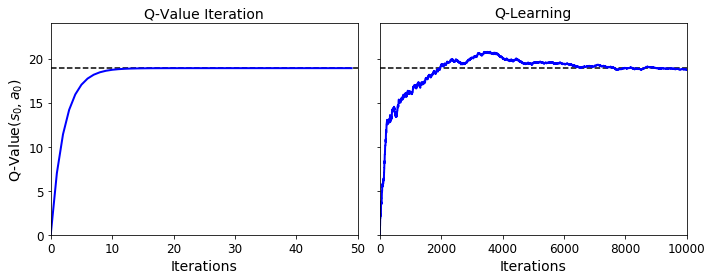

In [54]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot")

# Mạng Q Sâu

Hãy xây dựng DQN. Với một trạng thái, nó sẽ ước tính, cho mỗi hành động có thể xảy ra, tổng số điểm thưởng được chiết khấu trong tương lai mà nó có thể mong đợi sau khi thực hiện hành động đó (nhưng trước khi nó nhìn thấy kết quả của nó):

In [55]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

Để chọn một hành động sử dụng DQN này, ta chỉ chọn hành động có giá trị Q dự đoán lớn nhất. Tuy nhiên, để đảm bảo rằng tác nhân khám phá môi trường, ta chọn một hành động ngẫu nhiên có xác suất `epsilon`.

In [56]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

Ta cũng sẽ cần một bộ nhớ phát lại. Nó sẽ chứa các trải nghiệm của tác nhân, ở dạng tuple: `(obs, action, bonus, next_obs, done)`. Ta có thể sử dụng lớp `deque` cho việc đó (nhưng hãy nhớ xem [thư viện Reverb](https://github.com/deepmind/reverb) tuyệt vời của DeepMind để triển khai phát lại trải nghiệm mạnh mẽ hơn nhiều):

In [57]:
from collections import deque

replay_memory = deque(maxlen=2000)

Và hãy tạo một chức năng để lấy mẫu trải nghiệm từ bộ nhớ phát lại. Nó sẽ trả về 5 mảng NumPy: `[obs, actions, Rewards, next_obs, dones]`.

In [58]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

Bây giờ ta có thể tạo một hàm sử dụng DQN để phát một bước và ghi lại trải nghiệm của nó trong bộ nhớ phát lại:

In [59]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Cuối cùng, hãy tạo một hàm lấy mẫu một số trải nghiệm từ bộ nhớ phát lại và thực hiện một bước huấn luyện:

**Ghi chú**:
* 3 bản phát hành đầu tiên của ấn bản thứ 2 thiếu thao tác `reshape()` giúp chuyển đổi ` target_Q_values` thành một vector cột (điều này được yêu cầu bởi `loss_fn()`).
* Cuốn sách sử dụng tốc độ học là 1e-3, nhưng trong mã bên dưới tôi sử dụng 1e-2, vì nó cải thiện đáng kể việc huấn luyện. Chúng tôi cũng đã điều chỉnh tốc độ học của các biến thể DQN bên dưới.

In [60]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Và bây giờ, hãy huấn luyện mô hình!

In [61]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [62]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 200, eps: 0.010

Saving figure dqn_rewards_plot


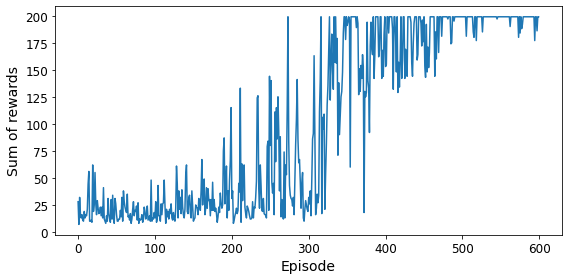

In [63]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [64]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

Không tệ chút nào! 😀

## DQN Kép

In [65]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [66]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [67]:
replay_memory = deque(maxlen=2000)

In [68]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode >= 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 599, Steps: 55, eps: 0.0100

Saving figure double_dqn_rewards_plot


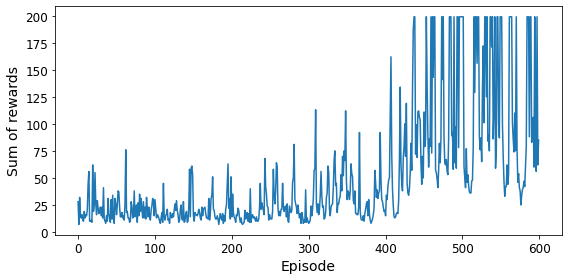

In [69]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [70]:
env.seed(43)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
   
plot_animation(frames)

# DQN Kép Đối kháng

In [71]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [72]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [73]:
replay_memory = deque(maxlen=2000)

In [74]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 200, eps: 0.010

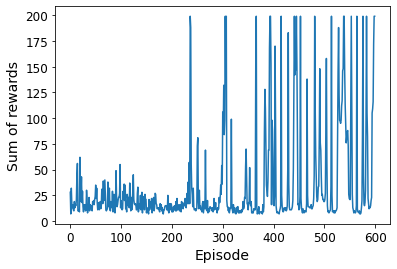

In [75]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [76]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

Trông có vẻ là một tác nhân khá mạnh mẽ!

In [77]:
env.close()

# Sử dụng TF-Agents để đánh bại Breakout

Hãy sử dụng TF-Agents để tạo một tác nhân học chơi Breakout. Ta sẽ sử dụng thuật toán Q-Learning Sâu để có thể dễ dàng so sánh các thành phần với lần triển khai trước đó, nhưng TF-Agents triển khai nhiều thuật toán khác (và phức tạp hơn)!

## Các môi trường TF-Agents

In [79]:
tf.random.set_seed(42)
np.random.seed(42)

In [80]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [81]:
env.gym

In [82]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [83]:
env.step(1) # Fire

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

Saving figure breakout_plot


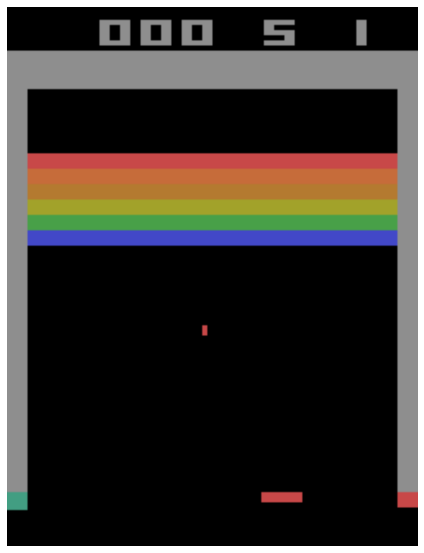

In [84]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [85]:
env.current_time_step()

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

## Thông số Môi trường

In [86]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [87]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [88]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

## Wrapper Môi trường

Bạn có thể bao môi trường TF-Agents trong wrapper TF-Agents:

In [89]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [90]:
repeating_env.unwrapped

Đây là danh sách của các wrapper có sẵn:

In [91]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls to the given environment.
RunStats                    Wrapp

Hàm `suite_gym.load()` có thể tạo một môi trường và bao nó cho bạn, cả với wrapper môi trường TF-Agents và wrapper môi trường Gym (cái sau được áp dụng trước).

In [92]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [93]:
limited_repeating_env

In [94]:
limited_repeating_env.unwrapped

Tạo một môi trường Atari Breakout và bao nó để áp dụng các bước tiền xử lý Atari mặc định:

**Cảnh báo**: Breakout yêu cầu người chơi nhấn nút FIRE khi bắt đầu trò chơi và sau mỗi lần mất mạng. Tác nhân có thể mất nhiều thời gian để học điều này vì lúc đầu có vẻ như nhấn FIRE chỉ có nghĩa là thua nhanh hơn. Để tăng tốc độ huấn luyện một cách đáng kể, ta tạo và sử dụng một lớp con của lớp wrapper `AtariPreprocessing` có tên là `AtariPreprocessingWithAutoFire` để tự động nhấn FIRE (tức là phát hành động 1) khi bắt đầu trò chơi và sau mỗi lần mất mạng. Điều này khác với việc sử dụng trình bao bọc `AtariPreprocessing` thông thường trong sách.

In [95]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            super().step(1) # FIRE to start after life lost
        return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4])

In [96]:
env

Chơi một vài bước để xem điều gì xảy ra:

In [97]:
env.seed(42)
env.reset()
for _ in range(4):
    time_step = env.step(3) # LEFT

In [98]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure preprocessed_breakout_plot


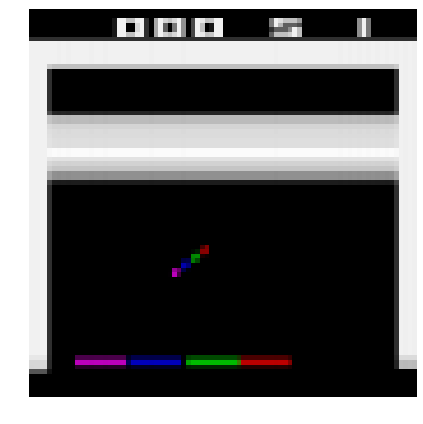

In [99]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

Chuyển môi trường Python sang môi trường TF:

In [100]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## Tạo DQN

Tạo một lớp nhỏ để chuẩn hóa các quan sát. Hình ảnh được lưu trữ bằng cách sử dụng byte từ 0 đến 255 để sử dụng ít RAM hơn, nhưng ta muốn chuyển số float từ 0.0 đến 1.0 sang mạng thần kinh:

Tạo Mạng Q:

In [101]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

Tạo Tác nhân DQN:

In [102]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

Tạo bộ đệm phát lại (điều này sẽ sử dụng nhiều RAM, vì vậy vui lòng giảm kích thước bộ đệm nếu bạn gặp lỗi hết bộ nhớ):

**Cảnh báo**: ta sử dụng bộ đệm phát lại có kích thước 100,000 thay vì 1,000,000 (như được sử dụng trong sách) do nhiều người gặp phải lỗi OOM (Hết bộ nhớ).

In [103]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000) # reduce if OOM error

replay_buffer_observer = replay_buffer.add_batch

Tạo một trình quan sát tùy chỉnh đơn giản để đếm và hiển thị số lần nó được gọi (ngoại trừ khi nó đi qua một quỹ đạo biểu thị ranh giới giữa hai tập, vì điều này không được tính là một bước):

In [104]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

Hãy thêm một số phép đo huấn luyện:

In [105]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [106]:
train_metrics[0].result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [107]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


Tạo trình điều khiển thu thập:

In [108]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

Thu thập những kinh nghiệm ban đầu, trước khi huấn luyện:

In [109]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

20000/20000

Hãy lấy mẫu 2 tập phụ, mỗi tập có 3 bước thời gian và hiển thị chúng:

**Lưu ý**: `replay_buffer.get_next()` không được dùng nữa. Thay vào đó, ta phải sử dụng `replay_buffer.as_dataset(..., single_deterministic_pass=False)`.

In [110]:
tf.random.set_seed(9) # chosen to show an example of trajectory at the end of an episode

#trajectories, buffer_info = replay_buffer.get_next( # get_next() is deprecated
#    sample_batch_size=2, num_steps=3)

trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))

In [111]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [112]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [113]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [114]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

Saving figure sub_episodes_plot


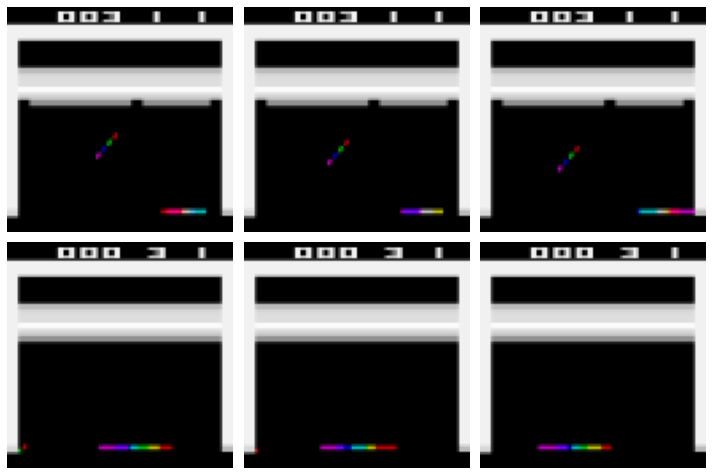

In [115]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

Bây giờ hãy tạo bộ dữ liệu:

In [116]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

Chuyển các hàm chính thành Hàm TF để hoạt động tốt hơn:

In [117]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

Và bây giờ ta đã sẵn sàng để chạy vòng lập chính!

In [118]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

Chạy ô tiếp theo để huấn luyện tác nhân trong 50,000 bước. Sau đó xem hành vi của nó bằng cách chạy ô tiếp sau. Bạn có thể chạy hai ô này bao nhiêu lần tùy thích. Các tác nhân sẽ tiếp tục cải thiện! Có thể sẽ mất hơn 200,000 lần lặp lại để tác nhân trở nên khá tốt.

In [119]:
train_agent(n_iterations=50000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


998 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 4004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 184.1999969482422


1998 loss:0.00181

INFO:absl: 
		 NumberOfEpisodes = 48
		 EnvironmentSteps = 8004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 182.39999389648438


2998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 12004


<<244 more lines>>


		 NumberOfEpisodes = 1003
		 EnvironmentSteps = 176004
		 AverageReturn = 5.099999904632568
		 AverageEpisodeLength = 246.5


44998 loss:0.00165

INFO:absl: 
		 NumberOfEpisodes = 1019
		 EnvironmentSteps = 180004
		 AverageReturn = 5.199999809265137
		 AverageEpisodeLength = 256.6000061035156


45998 loss:0.00136

INFO:absl: 
		 NumberOfEpisodes = 1035
		 EnvironmentSteps = 184004
		 AverageReturn = 4.599999904632568
		 AverageEpisodeLength = 252.1999969482422


46998 loss:0.00100

INFO:absl: 
		 NumberOfEpisodes = 1050
		 EnvironmentSteps = 188004
		 AverageReturn = 5.699999809265137
		 AverageEpisodeLength = 276.5


47998 loss:0.00116

INFO:absl: 
		 NumberOfEpisodes = 1063
		 EnvironmentSteps = 192004
		 AverageReturn = 5.900000095367432
		 AverageEpisodeLength = 296.3999938964844


48998 loss:0.00049

INFO:absl: 
		 NumberOfEpisodes = 1077
		 EnvironmentSteps = 196004
		 AverageReturn = 7.800000190734863
		 AverageEpisodeLength = 308.29998779296875


49999 loss:0.00073

In [120]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

Nếu bạn muốn lưu một GIF động để khoe tác nhân của mình với bạn bè, đây là một cách để thực hiện:

In [121]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [122]:
%%html
<img src="images/rl/breakout.gif" />

# Tài liệu bổ sung

## Deque vs Danh sách Luân phiên

Lớp `deque` cung cấp khả năng nối thêm nhanh, nhưng truy cập ngẫu nhiên khá chậm (đối với bộ nhớ phát lại lớn):

In [123]:
from collections import deque
np.random.seed(42)

mem = deque(maxlen=1000000)
for i in range(1000000):
    mem.append(i)
[mem[i] for i in np.random.randint(1000000, size=5)]

[121958, 671155, 131932, 365838, 259178]

In [124]:
%timeit mem.append(1)

47.4 ns ± 3.02 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [125]:
%timeit [mem[i] for i in np.random.randint(1000000, size=5)]

182 µs ± 6.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Ngoài ra, bạn có thể sử dụng một danh sách luân phiên như lớp `ReplayMemory` này. Điều này sẽ giúp truy cập ngẫu nhiên nhanh hơn đối với các bộ nhớ phát lại lớn:

In [126]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=np.object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [127]:
mem = ReplayMemory(max_size=1000000)
for i in range(1000000):
    mem.append(i)
mem.sample(5)

array([757386, 904203, 190588, 595754, 865356], dtype=object)

In [128]:
%timeit mem.append(1)

519 ns ± 17.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [129]:
%timeit mem.sample(5)

9.24 µs ± 227 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Tạo một Môi trường TF-Agents Tuỳ chỉnh

Để tạo môi trường Tác nhân TF tùy chỉnh, bạn chỉ cần viết một lớp kế thừa từ lớp `PyEnvironment` và triển khai một số phương thức. Ví dụ: môi trường tối thiểu sau biểu thị lưới 4x4 đơn giản. Tác nhân bắt đầu ở góc (0,0) và phải di chuyển đến góc đối diện (3,3). Tập kết thúc nếu tác nhân đạt được mục tiêu (nhận được điểm thưởng +10) hoặc nếu nhân viên vượt quá giới hạn (điểm thưởng -1). Các hành động là lên (0), xuống (1), trái (2) và phải (3).

In [130]:
class MyEnvironment(tf_agents.environments.py_environment.PyEnvironment):
    def __init__(self, discount=1.0):
        super().__init__()
        self._action_spec = tf_agents.specs.BoundedArraySpec(
            shape=(), dtype=np.int32, name="action", minimum=0, maximum=3)
        self._observation_spec = tf_agents.specs.BoundedArraySpec(
            shape=(4, 4), dtype=np.int32, name="observation", minimum=0, maximum=1)
        self.discount = discount

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros(2, dtype=np.int32)
        obs = np.zeros((4, 4), dtype=np.int32)
        obs[self._state[0], self._state[1]] = 1
        return tf_agents.trajectories.time_step.restart(obs)

    def _step(self, action):
        self._state += [(-1, 0), (+1, 0), (0, -1), (0, +1)][action]
        reward = 0
        obs = np.zeros((4, 4), dtype=np.int32)
        done = (self._state.min() < 0 or self._state.max() > 3)
        if not done:
            obs[self._state[0], self._state[1]] = 1
        if done or np.all(self._state == np.array([3, 3])):
            reward = -1 if done else +10
            return tf_agents.trajectories.time_step.termination(obs, reward)
        else:
            return tf_agents.trajectories.time_step.transition(obs, reward,
                                                               self.discount)

Thông số kỹ thuật hành động và quan sát nói chung sẽ là các phiên bản của các lớp `ArraySpec` hoặc `BoundedArraySpec` từ gói `tf_agents.specs` (xem thêm các thông số kỹ thuật khác trong gói này). Theo tùy chọn, bạn cũng có thể định nghĩa phương thức `render()`, phương thức `close()` để giải phóng tài nguyên, cũng như phương thức `time_step_spec()` nếu bạn không muốn `reward` và `discount` thành là số vô hướng float 32 bit. Lưu ý rằng lớp cơ sở đảm nhiệm việc theo dõi bước thời gian hiện tại, đó là lý do tại sao ta phải triển khai `_reset()` và `_step()` thay vì `reset()` và `step()`.

In [131]:
my_env = MyEnvironment()
time_step = my_env.reset()
time_step

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32))

In [132]:
time_step = my_env.step(1)
time_step

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32))

# Lời giải Bài tập

## 1. đến 7.

Xem Phụ lục A.

## 8.
_Bài tập:Sử dụng gradient chính sách để giải quyết môi trường LunarLander-v2 của OpenAI Gym.
Bạn sẽ cần cài đặt các phụ thuộc của Box2D (`%pip install -U gym[box2d]`)._

Hãy bắt đầy bằng việc tạo một môi trường LunarLander-v2:

In [133]:
env = gym.make("LunarLander-v2")

Đầu vào có 8 chiều:

In [134]:
env.observation_space

Box(-inf, inf, (8,), float32)

In [135]:
env.seed(42)
obs = env.reset()
obs

array([-0.00499964,  1.4194578 , -0.506422  ,  0.37943238,  0.00580009,
        0.11471219,  0.        ,  0.        ], dtype=float32)

Từ [mã nguồn](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py), ta có thể thấy rằng mỗi quan sát 8D này (x, y, h, v , a, w, l, r) tương ứng với:
* x,y: tọa độ của phi thuyền. Nó bắt đầu tại một vị trí ngẫu nhiên gần (0, 1,4) và phải hạ cánh gần mục tiêu tại (0, 0).
* h,v: tốc độ ngang và dọc của tàu vũ trụ. Nó bắt đầu với một tốc độ ngẫu nhiên nhỏ.
* a,w: góc nghiêng và vận tốc góc của phi thuyền.
* l,r: chân trái hay chân phải chạm đất (1.0) hay không (0.0).

Không gian hành động rời rạc, với 4 hành động có thể:

In [136]:
env.action_space

Discrete(4)

Nhìn vào [mô tả của LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/), những hành động này là:
* không làm gì cả
* cháy động cơ định hướng trái
* cháy động cơ chính
* cháy động cơ định hướng bên phải

Hãy tạo một mạng chính sách đơn giản với 4 nơ-ron đầu ra (một cho một hành động có thể):

In [137]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(n_outputs, activation="softmax"),
])

Lưu ý rằng ta đang sử dụng hàm kích hoạt softmax trong lớp đầu ra, thay vì hàm kích hoạt sigmoid như ta đã làm với môi trường CartPole-v1. Điều này là do ta chỉ có hai hành động khả thi đối với môi trường CartPole-v1, vì vậy mô hình phân loại nhị phân hoạt động tốt. Tuy nhiên, bây giờ ta có nhiều hơn hai hành động có thể, nên ta cần một mô hình phân loại nhiều lớp.

Tiếp theo, hãy sử dụng lại các hàm `play_one_step()` và `play_multiple_episodes()` mà ta đã định nghĩa mã cho Gradient chính sách CartPole-v1 ở trên, nhưng ta chỉ điều chỉnh hàm `play_one_step()` để giải thích cho mô hình bây giờ là một mô hình phân loại đa lớp chứ không phải là một mô hình phân loại nhị phân. Ta cũng điều hàm `play_multiple_episodes()` để gọi hàm `play_one_step()` đã điều chỉnh thay vì hàm ban đầu và ta sẽ thêm một hình phạt lớn nếu tàu vũ trụ không hạ cánh (hoặc gặp sự cố) trước số bước tối đa.

In [138]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(action[0, 0].numpy())
    return obs, reward, done, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = lander_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

Ta sẽ giữ nguyên các hàm `discount_rewards()` và `discount_and_normalize_rewards()` như trước:

In [139]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Bây giờ hãy thiết lập vài siêu tham số:

In [140]:
n_iterations = 200
n_episodes_per_update = 16
n_max_steps = 1000
discount_rate = 0.99

Một lần nữa, đây là là một mô hình phân loại đa lớp, nên chúng ta phải sử dụng entropy chéo phân loại thay vì entropy chéo nhị phân. Ngoài ra, hàm `lander_play_one_step()` đặt mục tiêu là chỉ số lớp thay vì xác suất lớp nên ta phải sử dụng hàm mất mát `sparse_categorical_crossentropy()`:

In [141]:
optimizer = keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

Ta đã sẵn sàng để huấn luyện mô hình! Bắt đầu thôi!

In [142]:
env.seed(42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print("\rIteration: {}/{}, mean reward: {:.1f}  ".format(
        iteration + 1, n_iterations, mean_reward), end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 200/200, mean reward: 134.2  

Hãy xem đồ thị quá trình học:

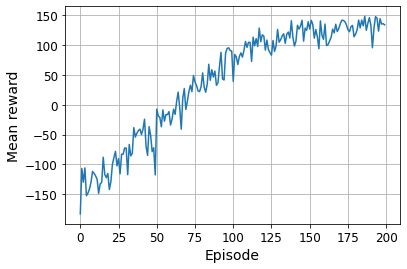

In [143]:
import matplotlib.pyplot as plt

plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

Bây giờ hãy xem kết quả!

In [144]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make("LunarLander-v2")
    env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0, 0].numpy())
        if done:
            break
    env.close()
    return frames

In [145]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

Khá tốt! Bạn có thể thử huấn luyện nó lâu hơn và/hoặc điều chỉnh các siêu tham số để xem liệu bạn có thể đưa nó lên hơn 200 hay không.

## 9.
_Bài tập: Sử dụng TF-Agents để huấn luyện một tác nhân có thể đạt được cấp độ siêu phàm (superhuman) trong trò Space Invaders-v4 bằng cách sử dụng bất kỳ thuật toán sẵn có nào._

Vui lòng làm theo các bước trong phần [Sử dụng TF-Agents để đánh bại Breakout](http://localhost:8888/notebooks/18_reinforcement_learning.ipynb#Using-TF-Agents-to-Beat-Breakout) ở trên, thay thế `"Breakout-v4"` với `"SpaceInvaders-v4"`. Tuy nhiên, sẽ có một vài thứ cần điều chỉnh. Ví dụ: trò chơi Space Invaders không yêu cầu người dùng nhấn FIRE để bắt đầu trò chơi. Thay vào đó, khẩu pháo laze của người chơi nhấp nháy trong vài giây rồi trò chơi tự động bắt đầu. Để có hiệu suất tốt hơn, bạn có thể bỏ qua giai đoạn nhấp nháy này (kéo dài khoảng 40 bước) ở đầu mỗi tập và sau mỗi lần mất mạng. Thật vậy, không thể làm bất cứ điều gì trong giai đoạn này và không có gì di chuyển. Một cách để làm điều này là sử dụng wrapper môi trường tùy chỉnh sau, thay vì wrapper `AtariPreprocessingWithAutoFire`:

In [146]:
class AtariPreprocessingWithSkipStart(AtariPreprocessing):
    def skip_frames(self, num_skip):
        for _ in range(num_skip):
          super().step(0) # NOOP for num_skip steps
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        self.skip_frames(40)
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            self.skip_frames(40)
        return obs, rewards, done, info

Hơn nữa, bạn phải luôn đảm bảo rằng các hình ảnh được tiền xử lý chứa đủ thông tin để chơi trò chơi. Ví dụ, các vụ nổ từ pháo laze và từ người ngoài hành tinh vẫn có thể nhìn thấy mặc dù độ phân giải hạn chế. Trong trường hợp cụ thể này, quá trình tiền xử lý mà ta đã thực hiện cho Breakout vẫn hoạt động tốt cho Space Invaders, nhưng đó là điều bạn nên kiểm tra nếu muốn thử các trò chơi khác. Để làm điều này, bạn có thể để tác nhân chơi ngẫu nhiên trong một thời gian và ghi lại các khung hình được tiền xử lý, sau đó phát hoạt ảnh và đảm bảo trò chơi vẫn có thể chơi được.

Bạn cũng cần để cho tác nhân huấn luyện trong một thời gian khá dài để có được hiệu suất tốt. Đáng buồn thay, thuật toán DQN không thể đạt đến cấp độ siêu phàm trong Space Invaders, có thể là do con người có thể học các chiến lược dài hạn hiệu quả trong trò chơi này, trong khi DQN chỉ có thể thành thạo các chiến lược khá ngắn. Nhưng đã có rất nhiều tiến bộ trong vài năm qua và giờ đây, nhiều thuật toán RL khác đã có thể vượt qua các chuyên gia con người trong trò chơi này. Hãy xem [Công nghệ tối tân dành cho Space Invaders trên paperwithcode.com](https://paperswithcode.com/sota/atari-games-on-atari-2600-space-invaders).

## 10.
_Bài tập: Nếu có dư khoảng $100, bạn có thể mua Raspberry Pi 3 cùng với một số thành phần robot giá rẻ, cài đặt TensorFlow trên Pi và thử bất kỳ những gì bạn muốn! Ví dụ, xem [sản phẩm thú vị](https://homl.info/2) này bởi Lukas Biewald, hoặc tham khảo GoPiGo hay BrickPi. Bắt đầu với những mục tiêu đơn giản, chẳng hạn như làm cho robot quay lại tìm góc sáng nhất (nếu nó được trang bị cảm biến ánh sáng) hoặc vật thể gần 
nhất (nếu có cảm biến sonar) và di chuyển theo hướng đó. Sau đó, bạn có thể bắt đầu sử dụng Học Sâu: ví dụ, nếu robot có camera, bạn có thể thử triển khai thuật toán phát hiện đối tượng để nó phát hiện người và di chuyển về phía họ. Bạn cũng có thể thử sử dụng RL để khiến tác nhân tự học cách sử dụng động cơ để đạt được mục tiêu đó. Chúc bạn có thật nhiều niềm vui!_

Bây giờ đến lượt bạn: điên cuồng, sáng tạo, nhưng trên hết, hãy kiên nhẫn và tiến lên từng bước, bạn sẽ làm được!